# RL Trading Agent Project Documentation

This notebook provides a comprehensive overview and usage guide for the RL Trading Agent project. The project uses reinforcement learning to train an agent to trade stocks based on engineered features from historical price data.

## Project Structure

```
RLTradingAgent/
├── agent/
│   ├── train.py         # Training script
│   ├── eval.py          # Evaluation script
│   ├── features.py      # Feature engineering and data splitting
│   ├── prepare_data.py  # Data preparation utility
│   └── env.py           # Custom trading environment
├── data/
│   ├── MSFT_train.csv   # Training data
│   ├── MSFT_test.csv    # Test data
│   └── MSFT_val.csv     # Validation data
└── documentation.ipynb  # This documentation
```

## 1. Data Preparation (`prepare_data.py`)

This script is responsible for preparing the dataset used by the trading agent.
It performs the following key steps:

1.1. Load raw market data — using the `load_data()` function from the features module.
The data is fetched for a specified stock ticker (e.g., `"MSFT"`) and returned as a Pandas DataFrame.

1.2. Split the dataset — via the `split_data()` function, which divides the data into three subsets:

- Training set — used for model fitting
- Validation set — used for tuning hyperparameters
- Test set — used for performance evaluation

1.3. Save the processed data — each subset is stored in the `data/` directory as separate CSV files

1.4. Clean header artifacts — after saving, the script removes unwanted duplicate header lines that may appear due to data concatenation or prior formatting.

1.5. Display output summary — prints the shape of the training dataset for verification.

Run from terminal:
```bash
python agent/prepare_data.py
```

Output files are saved in the `data/` directory.

In [2]:
from agent.features import load_data, split_data

if __name__ == "__main__":
    p_ticker = "MSFT"
    df = load_data(ticker=p_ticker)
    train_df, test_df, val_df = split_data(df)

    train_df.to_csv("data/"+p_ticker+"_train.csv", index=False)
    test_df.to_csv("data/"+p_ticker+"_test.csv", index=False)
    val_df.to_csv("data/"+p_ticker+"_val.csv", index=False)

    for file in ["data/"+p_ticker+"_train.csv", "data/"+p_ticker+"_test.csv", "data/"+p_ticker+"_val.csv"]:
        with open(file, "r") as f:
            lines = f.readlines()
        with open(file, "w") as f:
            f.writelines([lines[0]] + lines[2:])

    print("Train shape:", train_df.shape)

c:\Users\User\RLTradingAgent\agent\features.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers=ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


Price        Date        Open        High  ...      macd      rsi14 volume_change
Ticker                   MSFT        MSFT  ...                                   
49     2015-03-16   35.667435   35.813647  ... -0.491044  24.131319     -0.391917
50     2015-03-17   35.581419   35.977057  ... -0.494072  26.775110     -0.102062
51     2015-03-18   35.633031   36.837142  ... -0.435925  36.219223      0.395329
52     2015-03-19   36.346880   36.630707  ... -0.399810  36.219167     -0.233414
53     2015-03-20   36.604925   36.966156  ... -0.326476  41.961517      1.122385
...           ...         ...         ...  ...       ...        ...           ...
2511   2024-12-24  432.274691  437.197652  ...  4.103616  51.898961     -0.625924
2512   2024-12-26  436.680490  438.530341  ...  3.645740  45.130639      0.143723
2513   2024-12-27  432.224950  432.841557  ...  2.644089  37.684125      1.211040
2514   2024-12-30  423.731651  425.213499  ...  1.376974  31.144333     -0.273710
2515   2024-12-3

## 2. Feature Engineering (`features.py`)

The `features.py` module is responsible for **loading raw historical stock data** and computing a **set of derived features** that capture market dynamics relevant for reinforcement learning or predictive modeling.

### Main Functions

#### **2.1. `load_data()`**
This function downloads historical stock prices using the `yfinance` API and enriches them with several technical indicators commonly used in trading algorithms.

**Steps performed:**
1. **Download data:**  
   Retrieves OHLCV data (`Open`, `High`, `Low`, `Close`, `Volume`) for a selected stock ticker (default: `MSFT`).
2. **Compute log returns:**  
   np.log(df["Close"] / df["Close"].shift(1))
3. **Calculate moving averages:**  
   - `sma20` — 20-day simple moving average  
   - `sma50` — 50-day simple moving average
4. **Compute MACD (Moving Average Convergence Divergence):**  
   Difference between 12-day and 26-day exponential moving averages (`ema12 - ema26`).
5. **Calculate RSI (Relative Strength Index, period = 14):**  
   Measures the magnitude of recent price changes to identify overbought or oversold conditions.
6. **Compute volume change:**  
   Daily percentage change in traded volume.
7. **Finalize dataset:**  
   Removes missing values, resets the index, and returns a clean `pandas.DataFrame` ready for model training.


#### **2.2. `split_data()`**
This function splits the processed dataset into three chronological subsets for model development:

| Subset | Date Range | Purpose |
|--------|-------------|----------|
| **Train** | 2015–2020 | Used for fitting the model |
| **Test** | 2021–2023 | Used for model evaluation |
| **Validation** | 2024 | Used for fine-tuning and cross-validation |

The function filters the rows of the DataFrame based on the `"Date"` column and returns the three resulting subsets.



In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf

# load data and return filtered dataframe with additional trading features
def load_data(ticker="MSFT", start="2015-01-01", end="2025-01-01"):
    df = yf.download(tickers=ticker, start=start, end=end)
    
    df = df[["Open", "High", "Low", "Close", "Volume"]]
    
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["sma20"] = df["Close"].rolling(window=20).mean()
    df["sma50"] = df["Close"].rolling(window=50).mean()

    # --- MACD --- Moving Average Convergence Divergence
    ema12 = df["Close"].ewm(span=12, adjust=False).mean()
    ema26 = df["Close"].ewm(span=26, adjust=False).mean()
    df["macd"] = ema12 - ema26

    # RSI 14 - Relative Strength Index
    delta = df["Close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / (loss + 1e-9)
    df["rsi14"] = 100 - (100 / (1 + rs))

    # Volume change 
    df["volume_change"] = df["Volume"].pct_change()
    
    df = df.reset_index()
    df = df.dropna()

    return df

# splitting for the train, test and validation scopes.
def split_data(df, 
               train_start="2015-01-01", train_end="2020-12-31", 
               test_start="2021-01-01", test_end="2023-12-31",
               val_start="2024-01-01", val_end="2024-12-31"):
    print(df)
    train = df[(df["Date"] >= train_start) & (df["Date"] <= train_end)]
    test  = df[(df["Date"] >= test_start) & (df["Date"] <= test_end)]
    val   = df[(df["Date"] >= val_start) & (df["Date"] <= val_end)]
    return train, test, val


## 3. Trading Environment (`env.py`)

The `env.py` module defines a custom **Reinforcement Learning trading environment** built on top of the `gymnasium` library.  
It simulates market interactions for an RL agent that learns when to **buy**, **hold**, or **sell** a stock based on historical data.

### Overview

The environment provides:
- A **discrete action space** with three possible actions:  
  `0 = SELL`, `1 = HOLD`, `2 = BUY`
- A **continuous observation space** representing the most recent `window_size` (default 30) days of market indicators.

This setup allows agents (e.g., DQN, PPO, A2C) to learn trading policies from sequential price data.

### Main Components

#### **3.1. Initialization (`__init__`)**
The environment initializes key parameters:
- `df` — input DataFrame containing features from `features.py`
- `window_size` — number of past days forming the observation window
- `initial_balance` — starting cash balance
- `fee` — transaction fee for each trade

It also defines:
- `action_space = Discrete(3)`  
- `observation_space = Box(shape=(window_size * 6,))`, which includes six features per day:
  - `log_return`, `sma20`, `sma50`, `rsi14`, `macd`, and `volume_change`

#### **3.2. Observations (`_get_observation`)**
This helper method extracts the past 30 days of selected features and flattens them into a 1D NumPy array for input into the agent’s policy network.

#### **3.3. Environment Reset (`reset`)**
Resets the environment at the start of each episode:
- Resets cash balance, shares, and current step
- Returns an initial observation and `info` dictionary containing `balance`, `shares`, and `equity`

#### **3.4. Step Function (`step`)**
Executes a single time step given an action and updates the environment state.

**Reward design highlights:**
- **Buy (2):** Incentivized slightly (`+0.3`) but penalized if attempted with insufficient balance (`−0.8`)
- **Sell (0):** Rewards profitable trades proportionally to return; penalizes invalid sell actions
- **Hold (1):** Rewards holding profitable positions via `3 × log_return`, penalizes inactivity
- **Equity growth:** Additional reward proportional to relative equity change (`10 × Δequity`)
- **Volatility penalty:** Small negative term to discourage unstable behavior (`−0.2 × |log_return|`)

This reward system balances **profit-seeking** and **risk control**, encouraging the agent to grow equity steadily without excessive trading.

#### **3.5. Rendering**
The `render()` method prints the current step and total equity for monitoring during training.


In [ ]:

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd 

class TradingEnv(gym.Env):
    def __init__(self, df, window_size=30, initial_balance=10_000.0, fee=0.001):
        super(TradingEnv, self).__init__()

        self.df = df.reset_index(drop=True)
        self.window_size = window_size
        self.initial_balance = initial_balance
        self.fee = fee

        self.action_space = spaces.Discrete(3) # 0 = SELL, 1 = HOLD, 2 = BUY

        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(self.window_size * 6,),
            dtype=np.float32
        )

        self.reset()
    
    def _get_obsercation(self):
        frame = self.df.loc[self.current_step - self.window_size:self.current_step - 1,
                            ["log_return", "sma20", "sma50", "rsi14", "macd", "volume_change"]]
        obs = frame.values.flatten()
        return obs.astype(np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.shares = 0
        self.last_price = self.df.loc[self.current_step, "Close"]
        self.equity = self.balance
        self.reward = 0

        obs = self._get_obsercation()
        info = {"balance": self.balance, "shares": self.shares, "equity": self.equity}
        return obs, info

    def step(self, action):
        price = self.df.loc[self.current_step, "Close"]
        prev_equity = self.balance + self.shares * price
        log_r = self.df.loc[self.current_step, "log_return"]
        position = 1 if self.shares > 0 else 0
        reward = 0.0

        if action == 2:
            if self.balance > 0:
                reward += 0.3
                self.shares = (self.balance * (1 - self.fee)) / price
                self.balance = 0.0
                self.last_price = price
            else:
                reward -= 0.8

        if action == 0:
            if self.shares > 0:
                trade_profit = (price - self.last_price) / (self.last_price + 1e-9)
                reward += 10.0 * trade_profit
                self.balance = self.shares * price * (1 - self.fee)
                self.shares = 0
                reward += -0.02
                reward += 0.1
            else:
                reward -= 0.8

        elif action == 1:
            if position == 1:
                reward += 3.0 * log_r
            else:
                reward -= 0.8

        self.equity = self.balance + self.shares * price
        equity_change = (self.equity - prev_equity) / (prev_equity + 1e-9)
        reward += 10.0 * equity_change
        reward += -0.2 * abs(log_r)

        self.current_step += 1
        terminated = self.current_step >= len(self.df) - 1
        truncated = False

        obs = self._get_obsercation()
        info = {"balance": self.balance, "shares": self.shares, "equity": self.equity, "price": price, "reward": reward}

        return obs, reward, terminated, truncated, info
    
    def render(self):
        print(f"Step: {self.current_step}, Equity: {self.equity:.2f}")



## 4. Agent Training (`train_agent.py`)

This script trains a **reinforcement learning agent** using the **Proximal Policy Optimization (PPO)** algorithm from the `stable-baselines3` library.  
The agent interacts with the custom trading environment (`TradingEnv`) to learn profitable trading strategies through trial and error.

### Overview
The training process involves:
1. **Environment setup**
2. **Model configuration**
3. **Training loop execution**
4. **Model saving and logging**


### **4.1. Environment Setup**
The trading environment is wrapped with:
- `DummyVecEnv` — to make it compatible with vectorized parallel environments expected by Stable Baselines 3.
- `Monitor` — to log episode rewards, lengths, and performance metrics during training.

Example:
```python
env = DummyVecEnv([lambda: Monitor(TradingEnv(df, window_size=15), log_dir)])
```


### **4.2. PPO Model Configuration**
The agent uses a **Multilayer Perceptron (MLP)** policy network.

**Main hyperparameters:**
- `learning_rate = 3e-4` — step size for optimizer updates  
- `batch_size = 64` — number of samples per gradient update  
- `n_steps = 2048` — number of environment steps to run per update  
- `gamma = 0.99` — discount factor for future rewards  
- `gae_lambda = 0.95` — smoothing parameter for advantage estimation  
- `ent_coef = 0.02` — entropy regularization coefficient (encourages exploration)

All training logs are written to the `./logs/` directory for TensorBoard visualization.


### **4.3. Training and Saving**
The agent is trained for **100,000 timesteps** using the PPO algorithm.

After training completes, the model is saved in the file `ppo_trader.zip` for later evaluation or deployment.

**Command to run training:**
```bash
python agent/train_agent.py
```

In [ ]:
import os
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import pandas as pd
from agent.env import TradingEnv
from stable_baselines3.common.monitor import Monitor

if __name__ == "__main__":
    df = pd.read_csv("data/MSFT_train.csv")
    log_dir = "./logs/"
    os.makedirs(log_dir, exist_ok=True)
    
    env = DummyVecEnv([
        lambda: Monitor(TradingEnv(df, window_size=15), log_dir)
    ])

    model = PPO(
        "MlpPolicy",
        env,
        verbose=1,
        learning_rate=3e-4,
        batch_size=64,
        n_steps=2048,
        gamma=0.99,
        gae_lambda=0.95,
        ent_coef=0.02,
        tensorboard_log=log_dir
    )

    model.learn(total_timesteps=100_000)
    model.save("ppo_trader")

    print("Learning completed! Result is in ppo_trader.zip")



## 5. Model Evaluation (`eval_agent.py`)

This script evaluates the trained PPO trading agent on unseen test data and compares its performance to a **Buy & Hold** strategy.

### **5.1. Evaluation Process**
The model is loaded from the saved checkpoint (`ppo_trader.zip`) and tested on the **MSFT test dataset**.  
It uses the `evaluate_model()` function, which runs the agent through the entire market sequence without exploration (deterministic mode).

During evaluation:
- The agent interacts with the environment step-by-step.
- At each step, the agent decides whether to **BUY**, **HOLD**, or **SELL**.
- The total **equity curve** is recorded to measure profitability.

### **5.2. Performance Visualization**
After the simulation, equity progression is plotted against a baseline **Buy & Hold** growth curve:

```python
plt.plot(agent_equity, label="RL Agent")
plt.plot(bh_growth.values, label="Buy & Hold")
plt.legend()
plt.title("RL Agent vs Buy & Hold")
plt.show()
```

This provides an intuitive visualization of how the reinforcement learning agent performs compared to a passive investment strategy.

### **5.3. TensorBoard Integration**
The script also automatically launches **TensorBoard**, allowing you to visualize training metrics such as **total rewards**, **loss curves**, and **policy entropy**.  

These metrics help interpret the agent’s learning progress — for example, a rising **mean reward** curve usually indicates improved policy stability and profitability.

```python
tb = program.TensorBoard()
tb.configure(argv=[None, '--logdir', './logs'])
url = tb.launch()
print(f"✅ TensorBoard running at: {url}")
```

> 💡 Reward trend plot from TensorBoard (*"rollout/ep_rew_mean"* - Average total reward per episode) is ideal to demonstrate the model’s performance improvement over time.

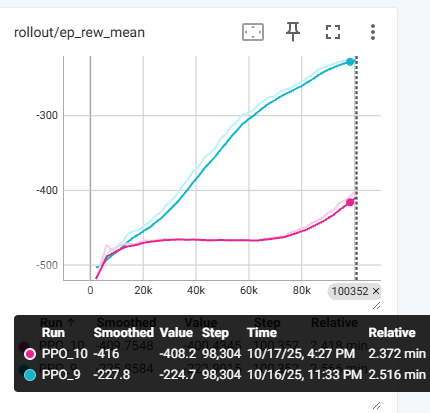


In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3 import PPO
from agent.env import TradingEnv
import collections
from tensorboard import program

def evaluate_model(model, df, window_size=15):
    env = TradingEnv(df, window_size=window_size)
    obs, info = env.reset()

    agent_equity = [info["equity"]]
    actions = []

    terminated = False
    truncated = False
    while not (terminated or truncated):
        action, _ = model.predict(obs, deterministic=True) 
        actions.append(action)
        obs, reward, terminated, truncated, info = env.step(action)
        agent_equity.append(info["equity"])

    return np.array(agent_equity), actions


if __name__ == "__main__":
    df_test = pd.read_csv("data/MSFT_test.csv")

    model = PPO.load("ppo_trader")

    agent_equity, actions = evaluate_model(model, df_test, window_size=15)

    action_map = {0: "SELL", 1: "HOLD", 2: "BUY"}
    decoded_actions = [action_map[int(a)] for a in actions]

    print(decoded_actions[:50])
    print(collections.Counter([int(a) for a in actions]))

    start_price = df_test["Close"].iloc[0]
    bh_growth = df_test["Close"] / start_price * agent_equity[0]

    plt.plot(agent_equity, label="RL Agent")
    plt.plot(bh_growth.values, label="Buy & Hold")
    plt.legend()
    plt.title("RL Agent vs Buy&Hold")
    plt.show()

    print("\n🚀 Launching TensorBoard...")
    tb = program.TensorBoard()
    tb.configure(argv=[None, '--logdir', './logs'])
    url = tb.launch()
    print(f"✅ TensorBoard running at: {url}")
    input("\nPress ENTER to close TensorBoard...\n")


## 6. References
- [Stable Baselines3 Documentation](https://stable-baselines3.readthedocs.io/)
- [OpenAI Gym](https://gym.openai.com/)
- [Pandas Documentation](https://pandas.pydata.org/)
- [yfinance Documentation](https://pypi.org/project/yfinance/)

---
For further questions, see code comments or contact the project maintainer. The project isn’t fully finished yet.